In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%cd ..

/home/ubuntu/sustaingym


In [2]:
import os

import numpy as np
import seaborn as sns
# import stable_baselines3 as sb3
from tqdm.auto import tqdm

from sustaingym.envs import CongestedElectricityMarketEnv
from sustaingym.envs.electricitymarket.plot_utils import *
from sustaingym.envs.electricitymarket.wrapped import DiscreteActions, CongestedDiscreteActions
from examples.electricitymarket.run_electricitymarket import *


sns.set_style("darkgrid", {"grid.color": ".6", "grid.linestyle": ":"})

In [3]:
env = CongestedElectricityMarketEnv(use_intermediate_rewards=True)
discrete_env = CongestedDiscreteActions(env)
reset_seed = 15
seeds = np.arange(30)

In [5]:
env = CongestedElectricityMarketEnv(month="2020-07",use_intermediate_rewards=True)

seeds = range(30)

results = run_random(seeds, env, False)

0it [00:00, ?it/s]

ep:  0
ep:  1
ep:  2
ep:  3
ep:  4
ep:  5
ep:  6
ep:  7
ep:  8
ep:  9
ep:  10
ep:  11
ep:  12
ep:  13
ep:  14
ep:  15
ep:  16
ep:  17
ep:  18
ep:  19
ep:  20
ep:  21
ep:  22
ep:  23


In [10]:
from collections import defaultdict

ep_rewards = np.sum(results['rewards'], axis=1)

lst_ep_rewards = list(ep_rewards)

rand_data = defaultdict(list)

rand_data['seeds'] = seeds
rand_data['ep_rewards'] = lst_ep_rewards

rand_df = pd.DataFrame(rand_data)
rand_df.to_csv('random_results.csv', index=False)

In [15]:
env = CongestedElectricityMarketEnv(month="2020-07",use_intermediate_rewards=True)

seeds = range(30)

results = run_mpc(seeds, env)

  0%|          | 0/30 [00:00<?, ?it/s]

seed number:  0


  0%|          | 0/288 [00:00<?, ?it/s]

ValueError: operands could not be broadcast together with shapes (37,) (36,) 

In [16]:
%debug

> /home/ubuntu/sustaingym/sustaingym/envs/battery/congested_electricity_market.py(1147)_calculate_price_taking_optimal()
   1145             net_price = prices + self.CARBON_PRICE * moers
   1146         else:
-> 1147             net_price = prices + self.CARBON_PRICE * moers[count:count+steps]
   1148         obj = net_price @ x + prices[-1] * cp.minimum(0, delta_energy[-1])
   1149         prob = cp.Problem(objective=cp.Maximize(obj), constraints=constraints)

*** NameError: name 'steos' is not defined
37
37
(36,)
252
(2,)


## Run offline models

In [16]:
opt_results = run_offline_optimal(seeds, env)
save_results(opt_results, seeds=seeds, path='examples/congested_intermreward/offline_results.npz')

  0%|          | 0/30 [00:00<?, ?it/s]

seed number:  0
calculating baseline no agent prices...
calculating optimal...
seed number:  1
calculating baseline no agent prices...
calculating optimal...
seed number:  2
calculating baseline no agent prices...
calculating optimal...
seed number:  3
calculating baseline no agent prices...
calculating optimal...
seed number:  4
calculating baseline no agent prices...
calculating optimal...
seed number:  5
calculating baseline no agent prices...
calculating optimal...
seed number:  6
calculating baseline no agent prices...
calculating optimal...
seed number:  7
calculating baseline no agent prices...
calculating optimal...
seed number:  8
calculating baseline no agent prices...
calculating optimal...
seed number:  9
calculating baseline no agent prices...
calculating optimal...
seed number:  10
calculating baseline no agent prices...
calculating optimal...
seed number:  11
calculating baseline no agent prices...
calculating optimal...
seed number:  12
calculating baseline no agent pri

In [4]:
opt_results = np.load('examples/congested_intermreward/offline_results.npz')
follow_results = congested_run_follow_offline_optimal(
    seeds, env,
    opt_dispatches=opt_results['dispatch'],
    opt_energies=opt_results['energy'])
save_results(follow_results, seeds=seeds, path='examples/congested_intermreward/follow_offline_results.npz')

  0%|          | 0/30 [00:00<?, ?it/s]

In [14]:
results = run_random(seeds, env, discrete=False)
save_results(results, seeds=seeds, path='examples/congested_intermreward/random_results.npz')

here


0it [00:00, ?it/s]

ep:  0
ep:  1
ep:  2
ep:  3
ep:  4
ep:  5
ep:  6
ep:  7
ep:  8
ep:  9


In [7]:
results = run_random(seeds, discrete_env, discrete=True)
save_results(results, seeds=seeds, path='examples/congested_intermreward/random_discrete_results.npz')

here


0it [00:00, ?it/s]

ep:  0
ep:  1
ep:  2
ep:  3
ep:  4
ep:  5
ep:  6
ep:  7
ep:  8
ep:  9
ep:  10
ep:  11
ep:  12
ep:  13
ep:  14
ep:  15
ep:  16
ep:  17
ep:  18
ep:  19
ep:  20
ep:  21
ep:  22
ep:  23
ep:  24
ep:  25
ep:  26
ep:  27
ep:  28
ep:  29


## Train RL Models

### PPO Models

In [3]:

%run examples/train_rllib -m 7 -i -a ppo -l 3e-03 -o ppo_summer_interm_lr3e-03

2023-06-04 08:08:23,587	INFO worker.py:1544 -- Started a local Ray instance. View the dashboard at 127.0.0.1:8267 
2023-06-04 08:08:24,176	INFO packaging.py:503 -- Creating a file package for local directory '/home/ubuntu/sustaingym/sustaingym'.
2023-06-04 08:08:24,360	INFO packaging.py:330 -- Pushing file package 'gcs://_ray_pkg_dc26e9820f58d0c9.zip' (56.29MiB) to Ray cluster...
2023-06-04 08:08:25,546	INFO packaging.py:343 -- Successfully pushed file package 'gcs://_ray_pkg_dc26e9820f58d0c9.zip'.


Env Config:  {'month': 7, 'eval month': None, 'discrete': False, 'interm_rewards': True}
Model Config:  {'algo': 'ppo', 'lr': 0.003, 'gamma': 0.9999, 'eval freq': 20, 'eval episodes': 5, 'log_dir': 'ppo_summer_interm_lr3e-03'}


2023-06-04 08:08:26,086	INFO algorithm_config.py:2899 -- Your framework setting is 'tf', meaning you are using static-graph mode. Set framework='tf2' to enable eager execution with tf2.x. You may also then want to set eager_tracing=True in order to reach similar execution speed as with static-graph mode.
2023-06-04 08:08:26,132	INFO algorithm.py:506 -- Current log_level is WARN. For more information, set 'log_level': 'INFO' / 'DEBUG' or use the -v and -vv flags.


Creating log directory at: ppo_summer_interm_lr3e-03


(RolloutWorker pid=1778449) 2023-06-04 08:08:30,149	WARNING env.py:156 -- Your env doesn't have a .spec.max_episode_steps attribute. Your horizon will default to infinity, and your environment will not be reset.
(RolloutWorker pid=1778449) 2023-06-04 08:08:30,149	WARNING env.py:166 -- Your env reset() method appears to take 'seed' or 'return_info' arguments. Note that these are not yet supported in RLlib. Seeding will take place using 'env.seed()' and the info dict will not be returned from reset.
2023-06-04 08:08:37,904	INFO trainable.py:172 -- Trainable.setup took 11.773 seconds. If your trainable is slow to initialize, consider setting reuse_actors=True to reduce actor creation overheads.
2023-06-04 08:08:37,907	WARNING util.py:67 -- Install gputil for GPU system monitoring.


Iteration 0


2023-06-04 08:09:11,845	WARNING ppo.py:440 -- The mean reward returned from the environment is 20.829078674316406 but the vf_clip_param is set to 10.0. Consider increasing it for policy: default_policy to improve value function convergence.


An Algorithm checkpoint has been created inside directory: '/home/ubuntu/ray_results/PPO_congested_market_2023-06-04_08-08-26qhc8_zkk/checkpoint_000001'.


 80%|████████  | 4/5 [05:03<01:15, 75.85s/it]

In [ ]:
# Trained on 2020 February data (evaluating on 2020 May data during training phase) with intermediate rewards and learning rate of 0.0003
%run examples/train_rllib -m 2 -v 5 -i -a ppo -l 0.0003 -o examples/interm_results

In [ ]:
# Trained on 2020 February data (evaluating on 2020 May data during training phase) with intermediate rewards and learning rate of 3e-05
%run examples/train_rllib -m 2 -v 5 -i -a ppo -l 3e-05 -o examples/interm_results

In [ ]:
# Trained on 2020 February data (evaluating on 2020 May data during training phase) with terminal rewards and learning rate of 0.003
%run examples/train_rllib -m 2 -v 5 -a ppo -l 0.003 -o examples/interm_results

In [ ]:
# Trained on 2020 February data (evaluating on 2020 May data during training phase) with terminal rewards and learning rate of 0.0003
%run examples/train_rllib -m 2 -v 5 -a ppo -l 0.0003 -o examples/interm_results

In [ ]:
# Trained on 2020 February data (evaluating on 2020 May data during training phase) with terminal rewards and learning rate of 3e-05
%run examples/train_rllib -m 2 -v 5 -a ppo -l 3e-05 -o examples/interm_results

## Read results and make plots

In [4]:
results_paths = {
    'oracle': 'examples/congested_intermreward/offline_results.npz',
    'follow oracle': 'examples/congested_intermreward/follow_offline_results.npz',
    'rand': 'examples/congested_intermreward/random_results.npz',
    'rand discrete': 'examples/congested_intermreward/random_discrete_results.npz',

    # 'PPO (2019)': os.path.join(ppo2019_model_dir, 'eval2021/results.npz'),
    # 'PPO (2021)': os.path.join(ppo2021_model_dir, 'eval2021/results.npz'),
    # 'PPO discrete (2019)': os.path.join(ppodiscrete2019_model_dir, 'eval2021/results.npz'),
    # 'PPO discrete (2021)': os.path.join(ppodiscrete2021_model_dir, 'eval2021/results.npz'),
    # 'SAC (2019)': os.path.join(sac2019_model_dir, 'eval2021/results.npz'),
    # 'SAC (2021)': os.path.join(sac2021_model_dir, 'eval2021/results.npz'),
    # 'DQN (2019)': os.path.join(dqn2019_model_dir, 'eval2021/results.npz'),
    # 'DQN (2021)': os.path.join(dqn2021_model_dir, 'eval2021/results.npz')
}

In [5]:
results = {label: np.load(path) for label, path in results_paths.items()}

In [10]:
results['oracle']['rewards']

array([[ 0.00000000e+00,  1.86707378e+01,  1.81200258e+01, ...,
        -1.76040959e+01, -1.75807413e+01, -1.75807413e+01],
       [ 0.00000000e+00,  2.00565370e+01,  1.89576713e+01, ...,
        -1.61993663e+01, -1.66796446e+01, -1.68136549e+01],
       [ 0.00000000e+00, -7.12704570e-13,  2.48396218e-11, ...,
        -1.76627867e+01, -1.75738986e+01, -1.73243459e+01],
       ...,
       [ 0.00000000e+00, -1.60809795e+01,  1.91495387e+01, ...,
        -1.53225144e+01, -1.54670906e+01, -1.54892087e+01],
       [ 0.00000000e+00,  1.42439524e+01,  1.45565113e+01, ...,
        -1.59671450e+01, -1.56231006e+01, -1.50509572e+01],
       [ 0.00000000e+00,  2.29475859e+01,  2.37575892e+01, ...,
        -2.07777559e+01, -1.94083257e+01, -1.85184649e+01]])

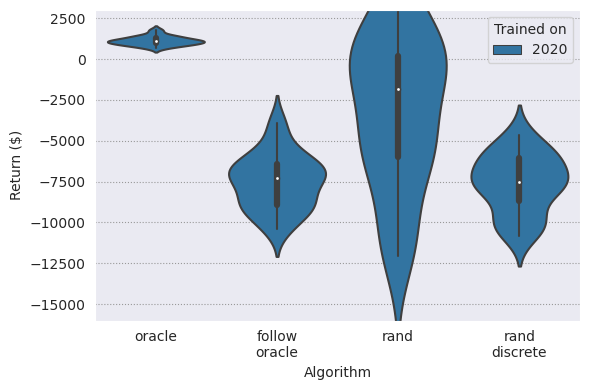

In [10]:
fig, ax = plot_returns(results, ylim=(-16000, 3000))
fig.savefig('plots/em_returns.png', dpi=300, pad_inches=0, bbox_inches='tight')

In [6]:
seed = 13
ep_data = {}
for label, d in results.items():
    data = {k: d[k][seed] for k in ['rewards', 'prices', 'energy']}
    data['model_name'] = label
    if 'SAC (2021)' in label:
        data['bids'] = d['actions'][seed]
    ep_data[label] = data

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


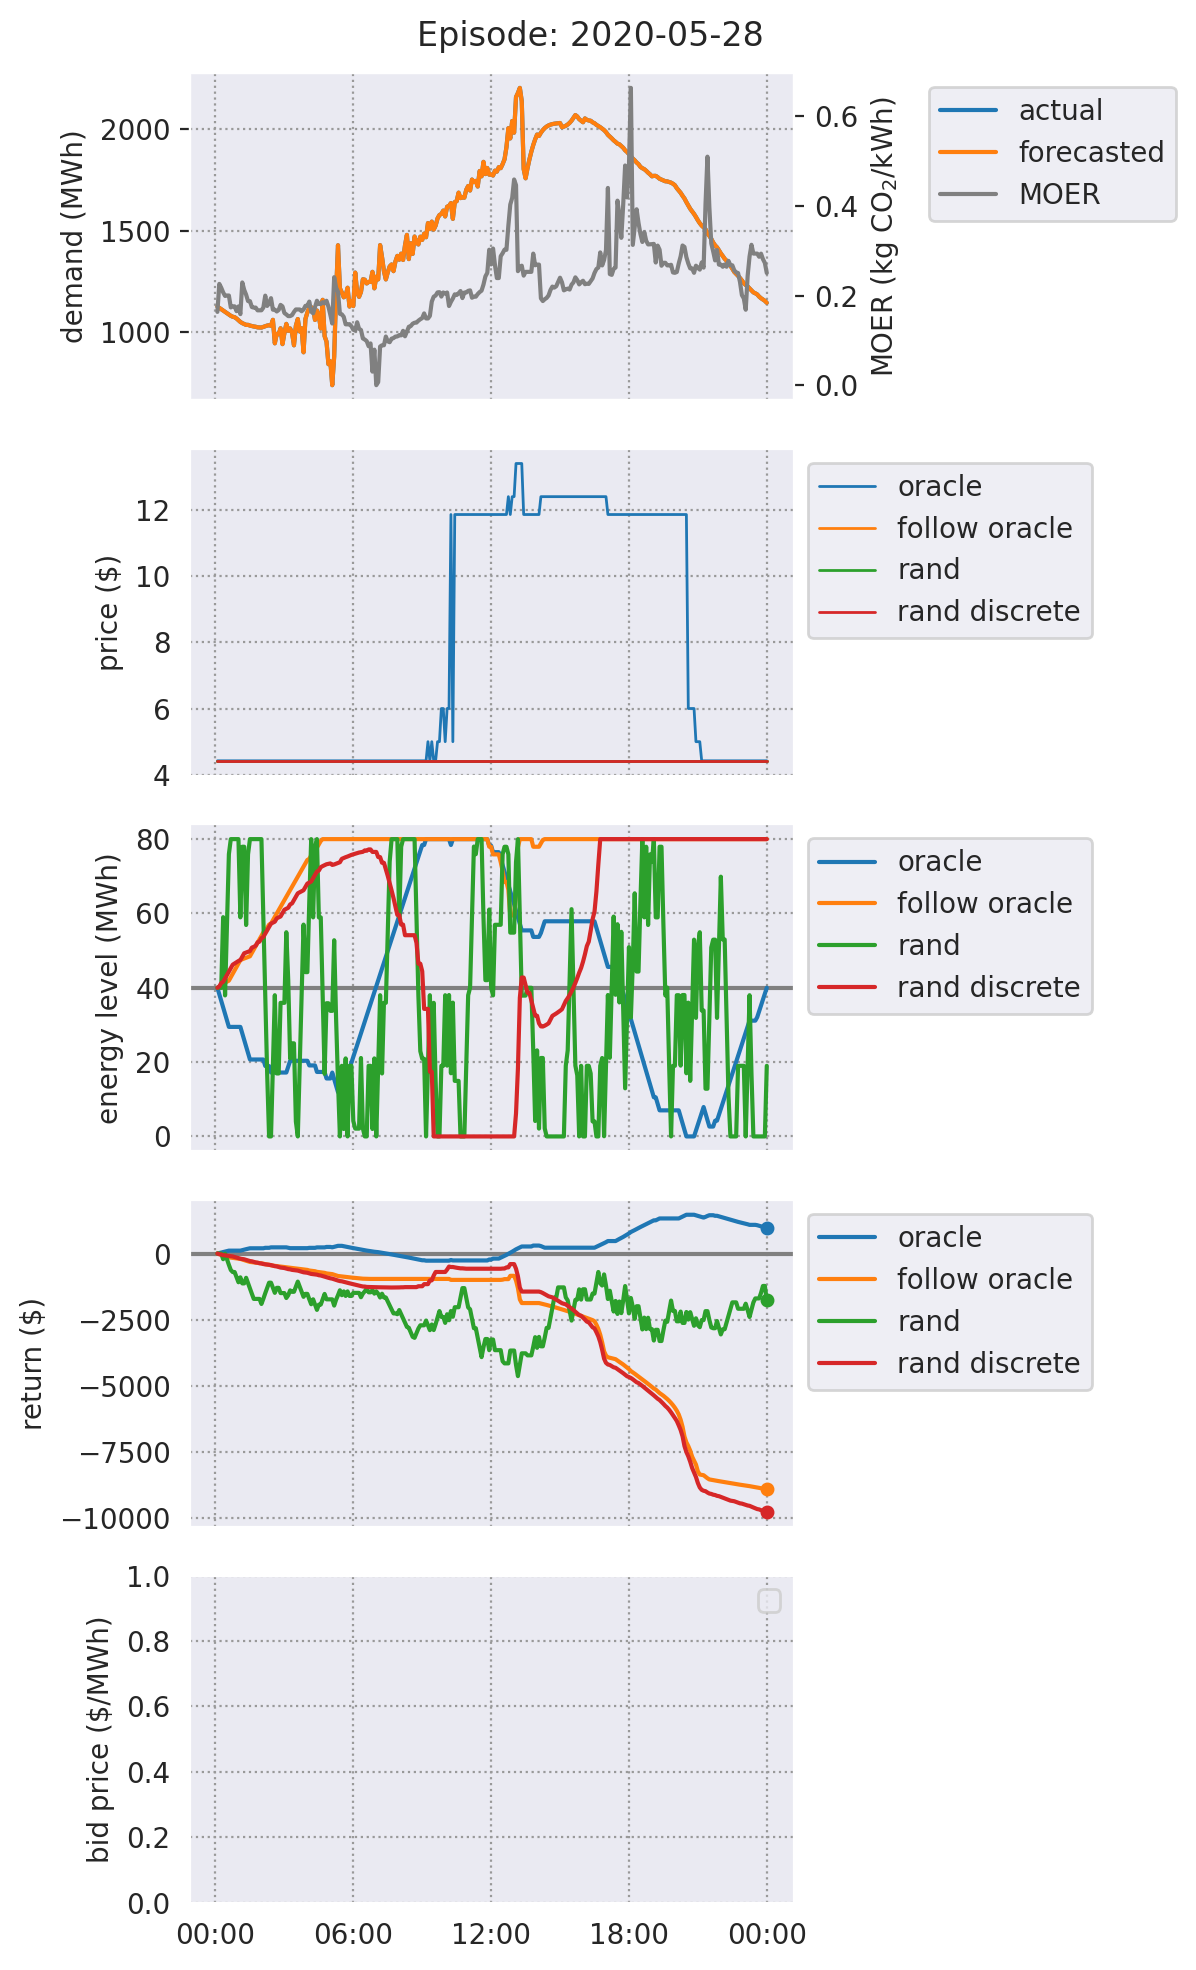

In [10]:
env.reset(seed)
fig, axs, times = setup_episode_plot(env, '2020-05', include_returns=True, include_bids=True)
for label in ['oracle', 'follow oracle', 'rand', 'rand discrete']:
    plot_episode(axs, times[:env.MAX_STEPS_PER_EPISODE], **ep_data[label])

for plot in ['prices', 'energy', 'rewards', 'bids']:
    axs[plot].legend(bbox_to_anchor=(1,1))

fig.savefig('plots/episode_plot.png', dpi=300, pad_inches=0, bbox_inches='tight')

In [103]:
max_price = env.action_space.high[0][0, 0]

env.settlement_interval = 12

charge_action = np.zeros((2,1))
# charge_action[:, 0] = np.array([max_price*0.95, max_price/0.95])
charge_action = np.array([[*charge_action], ] * (env.settlement_interval+1)).transpose().reshape(2,1,(env.settlement_interval+1))
charge_action[:, 0, 0] = np.array([max_price*0.95, max_price/0.95])

discharge_action = np.zeros((2,1))
# discharge_action[:, 0] = np.array([-10000, -100000])
discharge_action = np.array([[*discharge_action], ] * (env.settlement_interval+1)).transpose().reshape(2,1,(env.settlement_interval+1))
# discharge_action[:, 0, 0] = np.array([-10000, -10000])
discharge_action[:, 0, 0] = np.array([0, -max_price/0.95])

no_action = np.zeros((2,1))
# no_action[:, 0] = np.array([-100, max_price/0.95])
no_action = np.array([[*no_action], ] * (env.settlement_interval+1)).transpose().reshape(2,1,(env.settlement_interval+1))
no_action[:, 0, 0] = np.array([-max_price*0.95, max_price/0.95])

# env.reset(seed = 67)

# obs, reward, _, _ = env.step(charge_action)

# print("charge dispatch: ", env.dispatch)

env.reset()

obs, reward, _, _ = env.step(no_action)
obs, reward, _, _ = env.step(no_action)
obs, reward, _, _ = env.step(no_action)

# env.reset(seed = 67)

# obs, reward, _, _ = env.step(no_action)

# print("no action dispatch: ", env.dispatch)

# env.reset()

# while True:
#     action = env.action_space.sample()
#     obs, reward, done, _ = env.step(action)

#     if env.dispatch >= 0 or done:
#         print("dispatch: ", env.dispatch)
#         print("action: ", action[:, 0, 0])
#         break

discharge: [0.], charge: [-3.60167007e-10]
discharge: [0.], charge: [-1.11825216e-10]
discharge: [0.], charge: [-5.40150609e-08]


In [105]:
env.reset()

print("opportunity cost for returning to init charge: ", env._calculate_terminal_cost(40.))
print("opportunity cost for returning to below init charge: ", env._calculate_terminal_cost(20.))
print("opportunity cost for returning to above init charge: ", env._calculate_terminal_cost(60.))


opportunity cost for returning to init charge:  0
opportunity cost for returning to below init charge:  360.344496858183
opportunity cost for returning to above init charge:  0


In [10]:
import pandas as pd

df = pd.read_csv('../sustaingym/data/demand_data/DAY_AHEAD_regional_Load.csv')

days = set(df['Day'])
months = set(df['Month'])

for month in months:
    for day in days:
        hrs = df.loc[df['Month'] == month].loc[df['Day'] == day]['Period']

        if set(hrs) != {1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24}:
            print("Month: ", month)
            print("Day: ", day)

Month:  2
Day:  30
Month:  2
Day:  31
Month:  4
Day:  31
Month:  6
Day:  31
Month:  9
Day:  31
Month:  11
Day:  31
